In [2]:
import osmnx as ox

ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('northeuroperails_alt.graphml')

In [85]:
import networkx as nx

hki = ox.truncate_graph_bbox(graph, 60.308, 60.151, 25.243, 24.704, retain_all=True)
hki = hki.to_undirected()

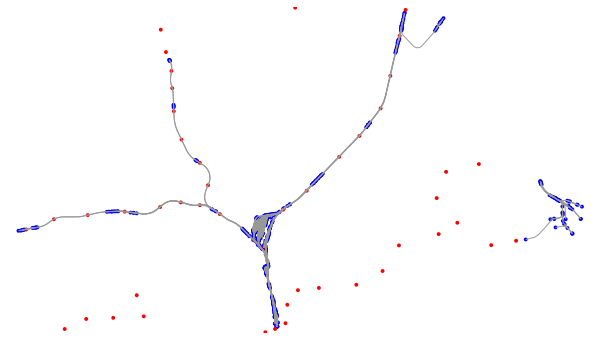

(<Figure size 1563.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b6a6e1340>)

In [82]:
node_colors = ['r' if 'railway' in d and d['railway'] == 'station' else 'b' for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)

In [68]:
hki.nodes[25710227]

{'y': 60.2624633,
 'x': 25.0285605,
 'osmid': 25710227,
 'railway': 'station',
 'name': 'Tapanila'}

In [86]:
ox.get_nearest_edge(hki, (60.22208, 24.87665))

(<shapely.geometry.linestring.LineString at 0x22b3938d370>,
 339826323,
 339854939)

In [87]:
hki[339826323][339854939]

AtlasView({0: {'osmid': [389604321, 321206408, 389604309, 30728254, 389604313, 389604314, 30728603, 389604317, 30728606], 'maxspeed': ['110', '80'], 'name': 'Leppävaaran kaupunkirata', 'oneway': False, 'length': 4110.2609999999995, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B3938D370>}})

In [72]:
import numpy as np
stations = np.array(
    [[k, v['x'], v['y']] for k, v in hki.nodes.items() if 'railway' in v and v['railway'] == 'station']
)
nearest = ox.get_nearest_edges(hki, stations[:, 1], stations[:, 2])

In [73]:
import numpy.linalg as npl

def is_point_on_edge(graph, edge, point, treshold):
    edge_start = graph.nodes[edge[0]]
    edge_end = graph.nodes[edge[1]]
    a = np.array([edge_end['x'] - edge_start['x'], edge_end['y'] - edge_start['y']])
    edge_len = npl.norm(a)
    a /= edge_len
    b = np.array([- a[1] / a[0], 1])
    b /= npl.norm(b)
    
    x = np.array([point[0] - edge_start['x'], point[1] - edge_start['y']])
    beta = (x[1]*a[0] - x[0]*a[1]) / (a[0]*b[1] - b[0]*a[1])
    if np.abs(beta) > treshold: return False
    alpha = (x[0] - beta * b[0]) / a[0]
    return alpha > 0 and alpha < edge_len

is_on_edge = {int(k): is_point_on_edge(hki, e, p, .01) for k, e, p in zip(stations[:, 0], nearest, stations[:, 1:])}
is_on_edge

{25474663: True,
 25477046: True,
 25710227: True,
 25710228: True,
 26432517: True,
 50818752: False,
 51074268: False,
 51334955: False,
 51335241: False,
 51425628: False,
 52607942: False,
 52609066: False,
 53834249: True,
 59594747: False,
 60289871: True,
 76388216: True,
 92560933: True,
 92567667: True,
 117926288: True,
 146450892: False,
 178275725: True,
 339605265: True,
 339833223: True,
 339835310: True,
 339840474: True,
 339842372: True,
 339842947: True,
 339848672: True,
 339850922: True,
 339856183: True,
 339861453: True,
 340019021: True,
 340021461: False,
 392940601: False,
 417945641: False,
 418089193: False,
 418089197: False,
 418089202: False,
 418089207: False,
 1041864527: False,
 1378007268: False,
 1516867775: True,
 2177226631: False,
 4248989440: True,
 4364527726: False,
 4364527727: False,
 4364527728: False,
 4364527729: False,
 4364527730: False,
 4364527731: False,
 4364527732: False,
 4364527733: False,
 4575281541: False,
 5421817304: False}

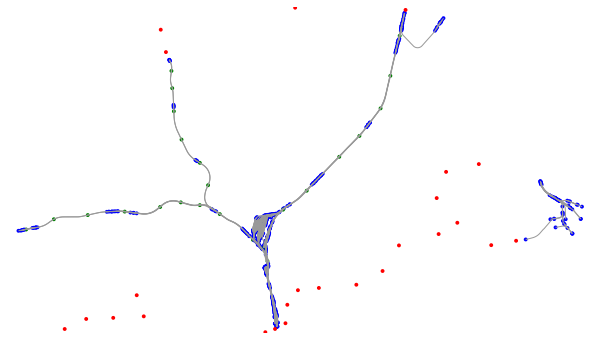

(<Figure size 1563.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4ad27a00>)

In [74]:
import networkx as nx

nx.set_node_attributes(hki, is_on_edge, 'is_on_edge')

def on_edge_node_color(n):
    if 'railway' not in n or n['railway'] != 'station':
        return 'b'
    if 'is_on_edge' not in n:
        return 'y'
    return 'g' if n['is_on_edge'] else 'r'

node_colors = [on_edge_node_color(d) for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)

In [4]:
hki[340018966]

AdjacencyView({340018968: {0: {'osmid': 30743883, 'maxspeed': '80', 'service': 'crossover', 'oneway': False, 'length': 67.985}}, 279995238: {0: {'osmid': 401430302, 'maxspeed': '80', 'name': 'Keravan kaupunkirata', 'oneway': False, 'length': 341.304, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B1C0334F0>}}, 1650982161: {0: {'osmid': [25683049, 401430298, 25682061, 464232240, 401430289, 25682066, 401430288, 401430266, 401430299, 25682332, 401430301, 401430302], 'maxspeed': ['80', '120'], 'name': 'Keravan kaupunkirata', 'oneway': False, 'length': 3582.213, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B1C031F40>}}})

In [88]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def erase_node(graph, node):
    lengths = {}
    edges_to_remove = []
    for adjacent, edges in graph[node].items():
        for eid, edata in edges.items():
            if adjacent in lengths:
                lengths[adjacent] = min(lengths[adjacent], edata['length'])
            else:
                lengths[adjacent] = edata['length']
            edges_to_remove.append((node, adjacent, eid))
    for e in edges_to_remove:
        graph.remove_edge(*e)
    for f, t in combinations(lengths, 2):
        graph.add_edge(f, t, length = lengths[f] + lengths[t])

def rewire_edge(graph, edge, node):
    edge_length = min(e['length'] for e in graph[edge[0]][edge[1]].values())
    edges_to_remove = []
    for e in graph[edge[0]][edge[1]]:
        edges_to_remove.append((edge[0], edge[1], e))
    for e in edges_to_remove:
        if 339826323 in e or 339854939 in e:
            print(e)
        graph.remove_edge(*e)
    p1 = (graph.nodes[edge[0]]['x'], graph.nodes[edge[0]]['y'])
    p2 = (graph.nodes[edge[1]]['x'], graph.nodes[edge[1]]['y'])
    pn = (graph.nodes[node]['x'], graph.nodes[node]['y'])
    dist1 = euclidean(p1, pn)
    dist2 = euclidean(p2, pn)
    total_dist = dist1 + dist2
    frac1 = dist1 / total_dist
    frac2 = dist2 / total_dist
    #graph.add_edge(edge[0], node, length = edge_length * frac1)
    #graph.add_edge(edge[1], node, length = edge_length * frac2)

nodes_to_remove = []
for n, d in hki.nodes.items():
    if 'railway' in d and d['railway'] == 'station':
        if hki.degree[n] > 0:
            continue
        p = (d['y'], d['x'])
        nearest = ox.get_nearest_edge(hki, p)
        if not is_point_on_edge(hki, (nearest[1], nearest[2]), (d['x'], d['y']), .01):
            erase_node(hki, n)
            nodes_to_remove.append(n)
        else:
            rewire_edge(hki,(nearest[1], nearest[2]), n)

for n in nodes_to_remove:
    hki.remove_node(n)

(339805585, 339826323, 0)
(339826323, 339845021, 0)
(339826323, 339854939, 0)


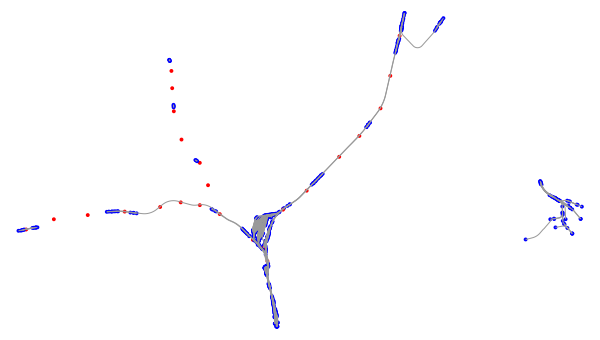

AdjacencyView({339856176: {0: {'osmid': 30728606, 'maxspeed': '110', 'name': 'Leppävaaran kaupunkirata', 'oneway': False, 'length': 13.697}}, 339854941: {0: {'osmid': 30728921, 'maxspeed': '80', 'service': 'crossover', 'oneway': False, 'length': 137.244, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022B3938D040>}}})

In [91]:
node_colors = ['r' if 'railway' in d and d['railway'] == 'station' else 'b' for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)
hki[339854939]

In [56]:
nodes_to_remove = []
for n, d in hki.nodes.items():
    if 'railway' not in d or d['railway'] != 'station':
        erase_node(hki, n)
        nodes_to_remove.append(n)

for n in nodes_to_remove:
    hki.remove_node(n)

25413724 {339767218: 40.46, 339760878: 44.16, 339708948: 548.587, 259158919: 88.84}
25413727 {339700099: 66.457, 6092589921: 1680.3349999999996, 3917073356: 205.4}
25413735 {339325720: 98.498, 339689028: 551.3009999999999, 25477062: 131.305}
25473241 {25473430: 289.88000000000005}
25473243 {25473431: 290.025}
25473244 {339727974: 410.203}
25473246 {339727994: 298.342}
25473370 {3915849579: 23.439, 339715276: 44.466, 25473577: 85.351, 6774004925: 421.33200000000005}
25473430 {259157806: 44.48, 339727926: 315.40000000000003}
25473431 {339727956: 45.879, 339727935: 265.159}
25473437 {339728042: 56.981, 3915849578: 179.388, 25473461: 407.93299999999994}
25473461 {339728042: 464.91399999999993, 3915849578: 587.3209999999999}
25473462 {25474663: 41.1948041038284}
25473463 {339718626: 550.21}
25473464 {25473576: 508.78}
25473519 {339727929: 45.063, 339727926: 43.704, 259155820: 264.399, 3393761832: 150.847}
25473520 {339727931: 55.052, 339727935: 43.403, 339727946: 90.825}
25473576 {339715241

339794760 {25477046: 325.94037346834017, 3917075267: 2023.149, 4523734500: 2880.4069999999997, 339805575: 4935.380999999999, 339805581: 4920.460999999999, 339805587: 5392.428999999999, 3917075257: 2124.643, 339805572: 4851.358, 3660682763: 3208.481, 3917073356: 3479.636, 6092589921: 5365.698, 3923385735: 5256.799999999999, 3660682758: 3520.879, 76388216: 4924.845520638995, 3923385737: 5513.905, 6769785470: 5979.746999999999, 3923385748: 6040.192, 6769785467: 6312.217999999999, 3660682760: 3686.499, 3923385749: 6365.148999999999, 3393761832: 3317.929, 3915849579: 3773.891, 6774004925: 4218.443, 1371700067: 4215.705, 3660682759: 3478.5319999999997, 25474663: 4093.6061958961714, 340203701: 3357.5660000000003, 1001543751: 3410.1619999999994, 3915849578: 3455.9480000000003, 3660682761: 3341.438, 3660682762: 3172.1459999999997, 3921177946: 5845.803, 3919011349: 5936.7080000000005, 1876126668: 5911.088, 1876126620: 5573.676, 1876126632: 5935.398, 339889857: 5916.959, 339800837: 5842.575}
3397

339885445 {3921046778: 19.698, 339885497: 27.086, 1876127279: 92.089}
339885458 {1876126806: 575.15, 1876127117: 326.13700000000006, 339894009: 531.4449999999999, 339889868: 609.1700000000001, 339885459: 129.841, 339889880: 639.993, 3921046778: 104.91499999999999, 339885500: 249.42899999999997}
339885459 {339889867: 586.249, 339889880: 631.03, 3921046778: 170.382, 339885500: 314.89599999999996, 1876126806: 704.991, 1876127117: 455.97800000000007, 339894009: 661.286, 339889868: 739.0110000000001}
339885497 {3921178363: 17.737, 1876127274: 106.701, 339885498: 163.186, 3919011349: 904.327, 339885500: 98.842, 1876127182: 1197.3049999999998, 1723772592: 2371.9970000000003, 1516868177: 638.209, 1516869162: 1368.158, 1516869116: 1238.866, 2389280592: 1845.381, 2389280595: 1843.96, 1876127337: 1191.9879999999998, 1876126934: 1918.601, 339914881: 1868.1209999999999, 339918243: 1708.3449999999998, 339919595: 1256.0369999999998, 339919567: 1925.4359999999997, 339919547: 1935.6229999999996, 339918

339901943 {3919334699: 753.468, 339911056: 862.0469999999999, 3919334659: 1074.6019999999999, 3919334657: 1067.455, 3919334661: 1036.16, 339904480: 1032.2350000000001, 1876127117: 1297.13, 1876126981: 1396.627, 1876126998: 1379.036, 339901948: 600.574, 1516868177: 836.9359999999999, 3921178363: 841.6049999999999, 1516869162: 1564.277, 1516869116: 1434.9850000000001, 2389280592: 2041.5, 2389280595: 2040.0789999999997, 1876127337: 1227.617, 1876126934: 1954.23, 339914881: 1903.75, 339918243: 1743.9739999999997, 339919595: 1291.6659999999997, 339919567: 1961.0649999999996, 339919547: 1971.2519999999995, 339918262: 1780.1709999999998, 339918292: 1810.739, 339918273: 1743.6109999999999, 1876127300: 1328.1349999999998, 3279384403: 1040.205, 3279384402: 1092.8649999999998, 3920956264: 1029.272, 339911098: 784.155, 339911115: 1039.069, 339925051: 1620.098, 3920956266: 1041.0140000000001, 3921138188: 1980.2789999999995, 339914838: 1999.7189999999996, 3917075257: 5130.766999999999, 6092589921: 2

339918243 {1876126934: 197.161, 1876127337: 933.1120000000002, 339919595: 792.854, 339919567: 420.635, 339919547: 430.82199999999995, 339918262: 319.451, 339918292: 365.456, 339918273: 1244.799, 1876127300: 829.3230000000001, 3279384403: 1314.0849999999998, 3279384402: 1366.745, 3920956264: 1303.152, 339925051: 1893.978, 3920956266: 1314.8939999999998, 1516869162: 2231.473, 1516868177: 1504.195, 1516869116: 2102.181, 2389280592: 2708.696, 2389280595: 2707.275, 3921138188: 278.935, 3917075257: 3338.7429999999995, 6092589921: 1050.128, 1876126620: 841.355, 1876126632: 1532.792, 3921177946: 1449.696, 3923385735: 1657.426, 3919011349: 1619.4699999999998, 1876126668: 1593.85, 3917073356: 3207.847, 3660682758: 4267.087, 76388216: 5419.861520638995, 3923385737: 6008.920999999999, 6769785470: 6474.762999999999, 3923385748: 6535.208, 6769785467: 6807.233999999999, 3660682760: 4181.515, 3923385749: 6860.164999999999, 3660682763: 4043.059, 4523734500: 3798.797, 25477046: 1967.0216265316596, 39170

339925051 {3920956266: 582.392, 3920956264: 973.8380000000001, 1876127337: 1377.621, 1876126934: 1452.368, 1876127300: 1478.1390000000001, 3279384403: 1103.3410000000001, 3279384402: 1156.0010000000002, 1516869162: 2107.597, 1516868177: 1380.3190000000002, 1516869116: 1978.3050000000003, 2389280592: 2584.82, 2389280595: 2583.3990000000003, 3921138188: 292.19100000000003, 3917075257: 4239.647999999999, 6092589921: 1951.033, 1876126620: 849.1279999999999, 1876126632: 2433.697, 3921177946: 2350.601, 3923385735: 2558.331, 3919011349: 2401.806, 1876126668: 2494.755, 3917073356: 4108.752, 3660682758: 5167.992, 76388216: 6320.766520638995, 3923385737: 6909.825999999999, 6769785470: 7375.667999999999, 3923385748: 7436.112999999999, 6769785467: 7708.138999999998, 3660682760: 5082.419999999999, 3923385749: 7761.069999999999, 3660682763: 4943.964, 4523734500: 4699.702, 25477046: 2867.9266265316596, 3917075267: 5182.826999999999, 3393761832: 5137.936, 3915849579: 5169.812, 6774004925: 5614.3640000

340203701 {1001543751: 135.311, 4523734500: 486.65000000000003, 25477046: 3683.5063734683404, 3917075267: 1424.645, 3917075257: 1150.969, 3660682763: 149.33, 3917073356: 1117.118, 6092589921: 3003.18, 3923385735: 2894.2819999999997, 3660682758: 398.618, 76388216: 2562.3275206389953, 3923385737: 3151.3869999999997, 6769785470: 3617.229, 3923385748: 3677.674, 6769785467: 3949.6999999999994, 3660682760: 616.124, 3923385749: 4002.631, 3393761832: 880.062, 3915849579: 727.62, 6774004925: 1297.8619999999999, 1371700067: 1124.4219999999998, 3660682759: 357.04900000000004, 25474663: 972.1231958961715, 3915849578: 97.91499999999999, 3660682761: 117.63400000000001, 3660682762: 103.16400000000002, 3921177946: 3483.285, 3919011349: 3574.19, 1876126668: 3548.57, 1876126620: 3211.1580000000004, 1876126632: 3572.88, 3921138188: 3914.2050000000004, 1876127300: 4591.504, 1876127337: 4883.502, 1876126934: 4147.551, 3279384403: 5416.736, 3279384402: 5469.396000000001, 3920956264: 5405.803, 3920956266: 54

1650982097 {339605265: 611.9178042806037, 1650982161: 143.589, 178275725: 2649.188862007906, 25710228: 1979.6697727440558}
1650982110 {6769785470: 7156.775, 6769785498: 6937.893, 1516867775: 5764.892204069574, 117926288: 4188.676650408845, 339605265: 6126.549195719397, 25710228: 4760.796227255945, 1650982163: 142.562, 25710227: 6618.647487206912, 178275725: 5121.3051379920935, 340019021: 4458.545990949984, 1936109363: 7195.459999999999, 3264074173: 4849.87, 1694837331: 5117.000999999999, 3923385748: 7271.249000000001, 3920712452: 3901.8370000000004, 2389280592: 6385.162, 2389280595: 6384.107, 1876127337: 6897.528, 1876126934: 7611.046, 1876127300: 6998.046, 3279384403: 6710.116, 3279384402: 6762.776, 3920956264: 6699.183, 3920956266: 6710.924999999999, 3921138188: 7582.2, 3917075257: 10710.457999999999, 6092589921: 8047.991, 1876126620: 8032.460999999999, 1876126632: 7742.531, 3921177946: 7564.236, 3923385735: 8518.817, 3919011349: 7435.7970000000005, 1876126668: 8455.241, 3917073356: 

1876126647 {1876126651: 33.467, 1876127050: 522.7239999999999, 1876126650: 70.97800000000001, 1876126649: 141.577, 3921177946: 325.117, 6092589921: 461.449, 3923385735: 932.275, 3919011349: 894.3190000000001, 1876126668: 868.6990000000001, 3917073356: 2482.6960000000004, 3660682758: 3541.936000000001, 76388216: 4694.710520638995, 3923385737: 5283.7699999999995, 6769785470: 5749.611999999999, 3923385748: 4808.933, 6769785467: 6082.082999999999, 3660682760: 3456.364, 3923385749: 6135.013999999999, 3660682763: 3317.908000000001, 3917075257: 3341.2399999999993, 4523734500: 3073.646, 25477046: 1969.5186265316597, 3917075267: 3896.824, 3393761832: 3511.8800000000006, 3915849579: 3543.7560000000008, 6774004925: 3988.3080000000004, 3660682759: 3499.5890000000004, 25474663: 4114.663195896172, 3915849578: 3565.096000000001, 3660682761: 3450.5860000000007, 3660682762: 3364.3080000000004, 1876126714: 792.1020000000001, 3921138188: 818.791, 1876127300: 1496.5500000000002, 1876127337: 1788.548, 1876

1876126822 {1876126852: 29.548000000000002, 1876126907: 765.585, 3921177946: 695.748, 6092589921: 832.08, 3923385735: 1302.906, 3919011349: 969.642, 3917073356: 2853.327, 3660682758: 3912.567000000001, 76388216: 5065.3415206389955, 3923385737: 5654.401, 6769785470: 6120.2429999999995, 3923385748: 5179.564, 6769785467: 6452.713999999999, 3660682760: 3826.995, 3923385749: 6505.6449999999995, 3660682763: 3688.5390000000007, 3917075257: 3711.870999999999, 4523734500: 3444.277, 25477046: 2340.149626531659, 3917075267: 4267.455, 3393761832: 3882.5110000000004, 3915849579: 3914.3870000000006, 6774004925: 4358.939, 3660682759: 3870.2200000000003, 25474663: 4485.294195896172, 3915849578: 3935.7270000000008, 3660682761: 3821.2170000000006, 3660682762: 3734.9390000000003, 3921138188: 1185.8020000000001, 1876127300: 1867.181, 1876127337: 2159.179, 1876126934: 1423.228, 3279384403: 2064.0, 3279384402: 2023.8290000000002, 3920956264: 2069.613, 3920956266: 2057.5999999999995, 2389280592: 3132.2659999

1876126981 {1876126998: 96.60300000000001, 1876127117: 650.829, 3919334661: 500.738, 3919334657: 608.796, 3919334699: 1062.835, 3919334659: 1383.969, 3921178363: 1260.06, 2389280592: 2037.656, 2389280595: 2036.2350000000001, 1876127337: 1536.984, 1876127300: 1637.502, 3279384403: 1349.5720000000001, 3279384402: 1402.232, 3920956264: 1338.6390000000001, 3920956266: 1350.381, 3921138188: 1322.2420000000002, 3917075257: 3848.3109999999997, 6092589921: 968.52, 3921177946: 832.1880000000001, 3923385735: 1439.3460000000002, 3919011349: 1106.0820000000003, 3917073356: 2989.7670000000007, 3660682758: 4049.0070000000005, 76388216: 5201.781520638996, 3923385737: 5029.263000000001, 6769785470: 6256.683, 3923385748: 4084.9540000000006, 6769785467: 6589.1539999999995, 3660682760: 3963.4350000000004, 3923385749: 6642.085, 3660682763: 3824.9790000000003, 4523734500: 3580.7170000000006, 25477046: 2476.5896265316596, 3917075267: 4403.895, 3393761832: 4018.951, 3915849579: 4050.827, 6774004925: 4495.379

1876127300 {1876127337: 948.268, 3279384403: 898.2459999999999, 3279384402: 950.906, 3920956264: 887.3129999999999, 3920956266: 899.055, 2389280592: 1870.6419999999998, 2389280595: 1869.221, 3921138188: 678.0610000000001, 3917075257: 3737.8689999999997, 6092589921: 1445.8610000000003, 3921177946: 1702.3250000000003, 3923385735: 1916.6870000000001, 3919011349: 1878.7310000000002, 3917073356: 3467.1080000000006, 3660682758: 4526.348000000001, 76388216: 5679.122520638995, 3923385737: 4750.64, 6769785470: 6734.023999999999, 3923385748: 3917.8770000000004, 6769785467: 7066.494999999999, 3660682760: 4440.776, 3923385749: 7119.4259999999995, 3660682763: 4302.320000000001, 4523734500: 4058.0580000000004, 25477046: 2366.1476265316596, 3917075267: 4681.048, 3393761832: 4496.292, 3915849579: 4528.168000000001, 6774004925: 4972.720000000001, 3660682759: 4484.001, 25474663: 5099.075195896172, 3915849578: 4549.508000000001, 3660682761: 4434.9980000000005, 3660682762: 4348.720000000001, 92560933: 336

3279384403 {3921138194: 674.5569999999999, 3920956264: 512.515, 3920956266: 524.2570000000001, 3921138188: 880.3629999999999, 3917075257: 4522.471, 6092589921: 1642.6799999999998, 3921177946: 1899.1439999999998, 3923385735: 2113.506, 3919011349: 1821.913, 3917073356: 3663.9270000000006, 3660682758: 4723.167, 76388216: 5875.941520638996, 3923385737: 2833.042, 6769785470: 6873.083, 3923385748: 3158.871, 6769785467: 7263.313999999999, 3660682760: 4637.595, 3923385749: 7316.245, 3660682763: 4499.139, 4523734500: 4254.877, 25477046: 3150.7496265316595, 3917075267: 5078.055, 3393761832: 4693.111, 3915849579: 4724.987, 6774004925: 5169.539000000001, 3660682759: 4680.820000000001, 25474663: 5295.894195896172, 3915849578: 4746.327, 3660682761: 4631.817, 3660682762: 4545.539000000001, 92560933: 4150.264550478448, 339835310: 6981.049242012939, 92567667: 5183.824779008485, 339856183: 9743.148500108138, 339850922: 11481.611683436717, 60289871: 12273.023922004475, 339861453: 10645.557775401574, 3923

3915849579 {6774004925: 444.7710000000001, 25474663: 747.0731958961715, 3923385749: 3564.551, 6769785467: 3603.0869999999995, 3923385737: 3057.5219999999995, 76388216: 2469.2155206389953, 6769785470: 3521.0809999999997, 3923385748: 3581.526, 3917073356: 1194.065, 6092589921: 3079.7089999999994, 3923385735: 2970.8109999999997, 3917075257: 1315.9560000000001, 4523734500: 645.138, 25477046: 3848.4933734683405, 3917075267: 1589.632, 3921177946: 3559.8140000000003, 3919011349: 3650.719, 3921138188: 3846.789, 3920956264: 4730.6, 3920956266: 4718.587, 92560933: 5810.801550478447, 339835310: 8641.58624201294, 92567667: 6844.361779008485, 339856183: 11403.685500108139, 339850922: 13142.148683436717, 60289871: 13933.560922004473, 339861453: 12306.094775401574, 3923386213: 5697.414000000001, 3921178363: 4573.869000000001, 3919334699: 5101.588000000001, 3919334659: 5422.722000000002, 3919334657: 4647.549000000001, 3919334661: 4416.271, 3921046778: 4509.676, 3921138194: 4053.6620000000003, 39209562

3920956244 {3921138194: 586.604, 3921138188: 795.4739999999999, 3920956264: 606.294, 3920956266: 618.0360000000001, 6092589921: 1559.693, 3921177946: 1816.1570000000002, 3923385735: 2030.519, 76388216: 5792.954520638996, 3923385737: 2926.821, 6769785470: 6847.856, 3923385748: 3252.65, 6769785467: 7180.326999999999, 3923385749: 7233.258, 4523734500: 4171.89, 25477046: 3067.7626265316594, 6774004925: 5086.552000000001, 25474663: 5212.855195896172, 92560933: 4067.2775504784477, 339835310: 6898.062242012939, 92567667: 5100.837779008485, 339856183: 9660.161500108139, 339850922: 11398.624683436718, 60289871: 12190.036922004476, 339861453: 10562.570775401575, 3923386213: 1397.278, 3921178363: 993.864, 3921046778: 1057.2749999999999, 3920956250: 1525.2259999999999, 6769785498: 6747.979999999999, 1516867775: 5751.329204069573, 117926288: 4175.113650408844, 339605265: 6193.848195719396, 25710228: 4828.095227255944, 25710227: 13422.542487206912, 178275725: 11925.200137992093, 340019021: 11262.440

4523734500 {25477046: 3206.34737346834, 6092589921: 2609.272, 76388216: 2168.746520638995, 6769785470: 3057.1, 6769785467: 3556.1189999999992, 6774004925: 1089.909, 25474663: 1043.1371958961718, 92560933: 5187.224550478447, 339835310: 8018.009242012939, 92567667: 6220.784779008484, 339856183: 10780.52150010814, 339850922: 12518.984683436718, 60289871: 13310.396922004475, 339861453: 11682.930775401575, 6769785498: 3778.0669999999996, 1516867775: 9163.406204069575, 117926288: 6518.721349591155, 339605265: 9605.925195719397, 25710228: 8240.172227255945, 25710227: 16834.61948720691, 178275725: 15337.277137992094, 340019021: 14674.517990949984, 4248989440: 3830.625549297177}
4604120244 {5437368259: 1083.298}
5437368259 {}
6092589921 {76388216: 1283.0294793610046, 6769785470: 1162.8029999999999, 6769785467: 5618.035999999998, 25477046: 1592.5076265316598, 6774004925: 3524.2609999999995, 25474663: 3650.5641958961714, 92560933: 2592.0225504784476, 339835310: 5422.807242012939, 92567667: 3625.5

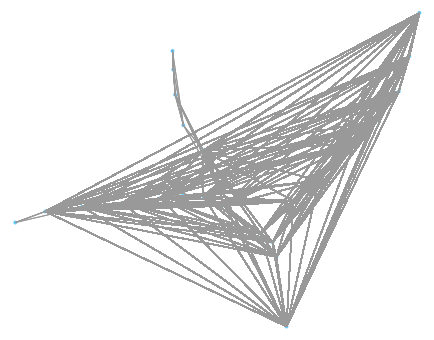

(<Figure size 1121.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b3db8f940>)

In [53]:
ox.plot_graph(hki)